# Human Activity Recognition — Random Forest Notebook

This notebook focuses on the Random Forest experiments and assumes you already have separate train/test CSV files. It will load TRAIN_CSV and TEST_CSV, align features, fit preprocessors on training only, train RF models, run tuning templates, and save models and preprocessors.

Authors: girdauskaite + partner


## 0) Install (run if needed)
Uncomment the pip line if packages missing.

In [16]:
# !pip install scikit-learn shap matplotlib seaborn joblib
print('skip install if already done')

skip install if already done


## 1) Imports & config

In [17]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
import joblib
import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 42
os.makedirs('models', exist_ok=True)
print('imports done')

imports done


In [ ]:
TRAIN_CSV = '../data/activity_train.csv'   # path to your train CSV
TEST_CSV  = '../data/activity_test.csv'    # path to your test CSV

label_map = {
    1:'WALKING', 2:'WALKING_UPSTAIRS', 3:'WALKING_DOWNSTAIRS',
    4:'SITTING', 5:'STANDING', 6:'LAYING',
    7:'STAND_TO_SIT', 8:'SIT_TO_STAND', 9:'SIT_TO_LIE',
    10:'LIE_TO_SIT', 11:'STAND_TO_LIE', 12:'LIE_TO_STAND'
}
RANDOM_STATE = 42
print('config ready')

config ready


## 2) Load train & test CSVs and align features
Make sure test file is labeled. If it isn't, set TEST_CSV to the unlabeled file — the notebook will still load and align features but evaluation requires labels.

In [19]:
df_train = pd.read_csv(TRAIN_CSV)
df_test = pd.read_csv(TEST_CSV)
print('train shape:', df_train.shape)
print('test  shape:', df_test.shape)

if 'activity' not in df_train.columns:
    raise ValueError('TRAIN_CSV must contain `activity` column')

has_test_labels = 'activity' in df_test.columns
print('test has activity labels?', has_test_labels)

# Prepare X_train, y_train, X_test, y_test
X_train = df_train.drop(columns=['activity'])
y_train = df_train['activity'].copy()
if has_test_labels:
    X_test = df_test.drop(columns=['activity'])
    y_test = df_test['activity'].copy()
else:
    X_test = df_test.copy()
    y_test = None

# Align columns: ensure test has same columns as train (add missing with 0, drop extras)
train_cols = list(X_train.columns)
test_cols = list(X_test.columns)
missing_in_test = [c for c in train_cols if c not in test_cols]
extra_in_test = [c for c in test_cols if c not in train_cols]
if missing_in_test:
    print('Adding missing columns to test:', missing_in_test[:10], '...')
    for c in missing_in_test:
        X_test[c] = 0.0
if extra_in_test:
    print('Dropping extra columns from test:', extra_in_test[:10], '...')
    X_test.drop(columns=extra_in_test, inplace=True)

# Reorder test columns to match train
X_test = X_test[train_cols]
print('final shapes -> X_train:', X_train.shape, 'X_test:', X_test.shape)

# Save column order for inference
joblib.dump(train_cols, 'models/feature_columns_order.joblib')
print('saved feature column order to models/feature_columns_order.joblib')

train shape: (7767, 562)
test  shape: (3162, 562)
test has activity labels? True
final shapes -> X_train: (7767, 561) X_test: (3162, 561)
saved feature column order to models/feature_columns_order.joblib


## 3) Quick cleaning: drop constant columns (computed on train) and apply to test

In [20]:
const_cols = X_train.columns[X_train.nunique() <= 1].tolist()
print('constant cols found on train:', len(const_cols))
if const_cols:
    X_train.drop(columns=const_cols, inplace=True)
    X_test.drop(columns=const_cols, inplace=True)
    print('dropped constant cols from train and test')
print('feature count after cleaning:', X_train.shape[1])
#joblib.dump({'const_cols': const_cols}, 'models/const_cols.joblib')

constant cols found on train: 0
feature count after cleaning: 561


## 4) Baseline RandomForest (train on training set, evaluate on test set)

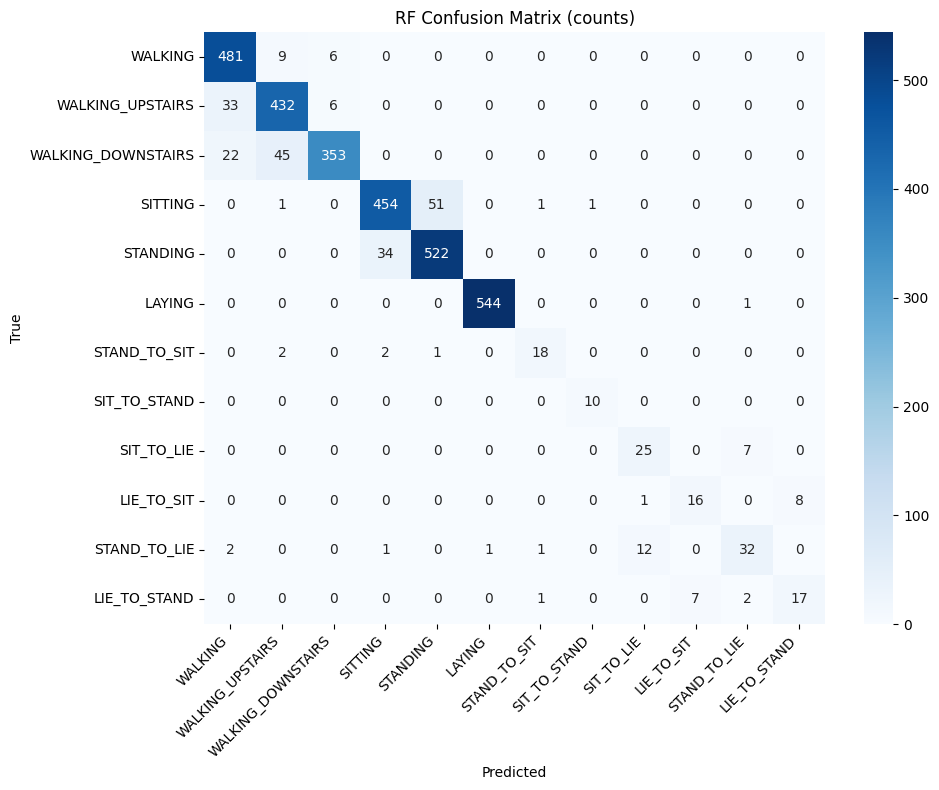

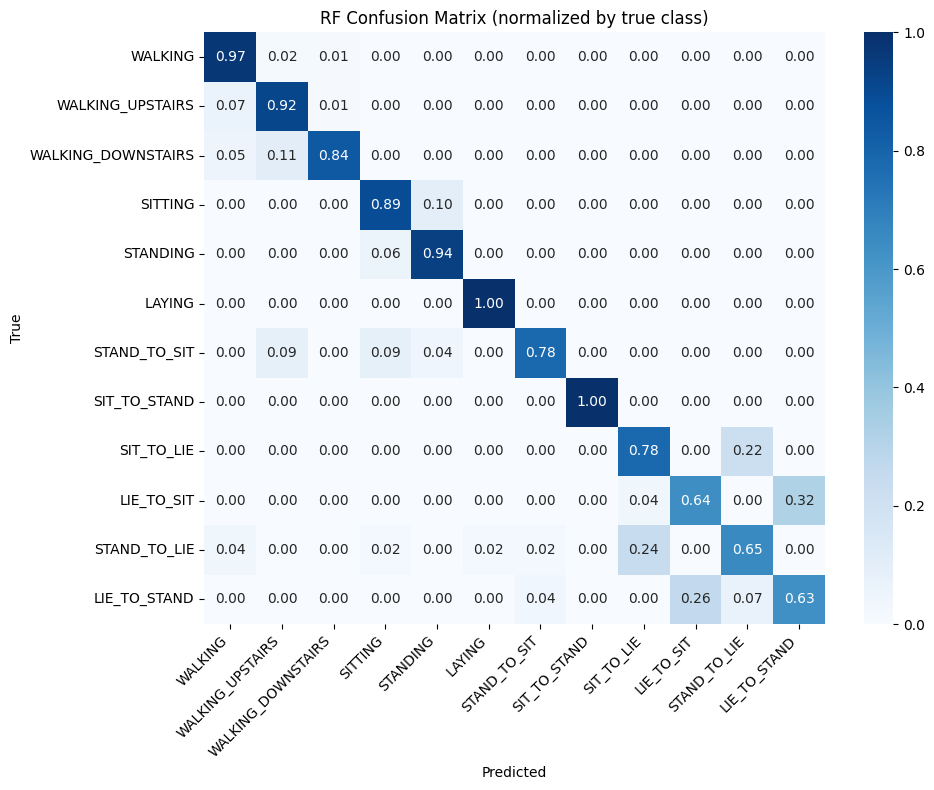

In [24]:
rf = RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1, class_weight='balanced')
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test) if 'y_pred' not in globals() else y_pred

# unique labels in the test set (preserves order)
labels = np.unique(y_test)

# map numeric labels -> readable names; handle 0-based vs 1-based labels
def label_name(v):
    # if your label_map keys are 1..12 and test labels are 0..11, add 1
    key = int(v if v in label_map else (v + 1))
    return label_map.get(key, str(v))

label_names = [label_name(v) for v in labels]

# raw confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=labels)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('RF Confusion Matrix (counts)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# normalized (by true class) confusion matrix
cm_norm = confusion_matrix(y_test, y_pred, labels=labels, normalize='true')
plt.figure(figsize=(10,8))
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('RF Confusion Matrix (normalized by true class)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 5) Hyperparameter tuning template (RandomizedSearchCV)
Tune using training data with internal CV (do not use test set for tuning). The template below runs randomized search on training data with StratifiedKFold.
Uncomment to run. Save best model and evaluate once tuning completes.

In [25]:
param_dist = {
    'n_estimators': [100,200,400,800],
    'max_depth': [None, 10, 20, 40],
    'min_samples_split': [2, 4, 8],
    'min_samples_leaf': [1, 2, 4]
}
cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=RANDOM_STATE)
rnd = RandomizedSearchCV(RandomForestClassifier(class_weight='balanced', random_state=RANDOM_STATE, n_jobs=-1),
                         param_distributions=param_dist, n_iter=12, scoring='f1_macro', cv=cv, verbose=1, random_state=RANDOM_STATE)

# Fit on training data only (uncomment to run):
rnd.fit(X_train, y_train)
print('best params', rnd.best_params_)
best_rf = rnd.best_estimator_
#joblib.dump(best_rf, 'models/rf_best.joblib')
print('saved rf_best')
# Evaluate on test set:
y_pred_best = best_rf.predict(X_test)
print('Test Macro F1 (best rf):', f1_score(y_test, y_pred_best, average='macro'))

# print('RandomizedSearchCV template ready — uncomment the fit lines to run tuning on training data.')

Fitting 4 folds for each of 12 candidates, totalling 48 fits
best params {'n_estimators': 200, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_depth': 10}
saved rf_best
Test Macro F1 (best rf): 0.8223995367429388


## 6) Feature importance & SHAP (template)
Use feature_importances_ for a quick view; SHAP for deeper analysis (install shap). Use a sample of test set for SHAP to speed up.

tGravityAcc_Min_2                0.019659
tGravityAcc_Max_2                0.018674
tGravityAcc_Mean_1               0.017184
tYAxisAcc_AngleWRTGravity_1      0.016724
tXAxisAcc_AngleWRTGravity_1      0.016298
tGravityAcc_Min_1                0.015898
tGravityAcc_Energy_1             0.015435
tBodyAcc_Mean_1                  0.015285
tGravityAcc_Mean_2               0.014734
tBodyAcc_ropy_1                  0.011941
tBodyAcc_Mean_2                  0.011482
tBodyAcc_Max_1                   0.010700
tGravityAcc_Max_1                0.009276
tGravityAcc_ropy_1.1             0.008576
tGravityAcc_Energy_2             0.008327
tBodyAcc_ropy_1.1                0.008282
fBodyAccJerk_BandsEnergyOld_1    0.007705
tBodyAccJerk_IQR_1               0.006991
fBodyAcc_MaxInds_1               0.006951
tZAxisAcc_AngleWRTGravity_1      0.006275
tBodyGyro_Energy_1               0.006265
fBodyAcc_MeanFreq_2              0.006256
tGravityAcc_ARCoeff_5            0.006124
tGravityAccMag_SMA_1             0

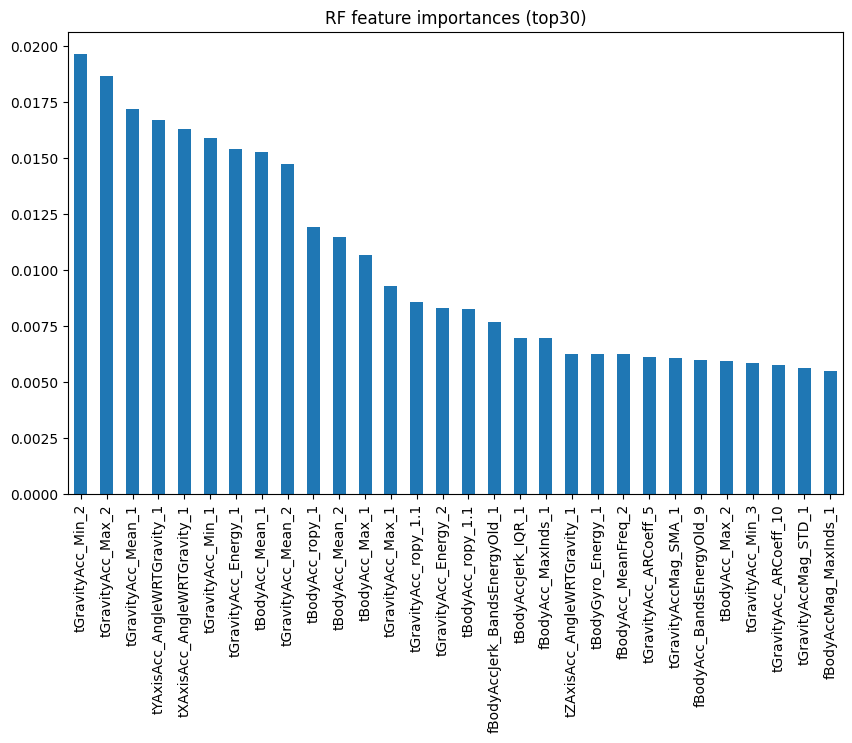

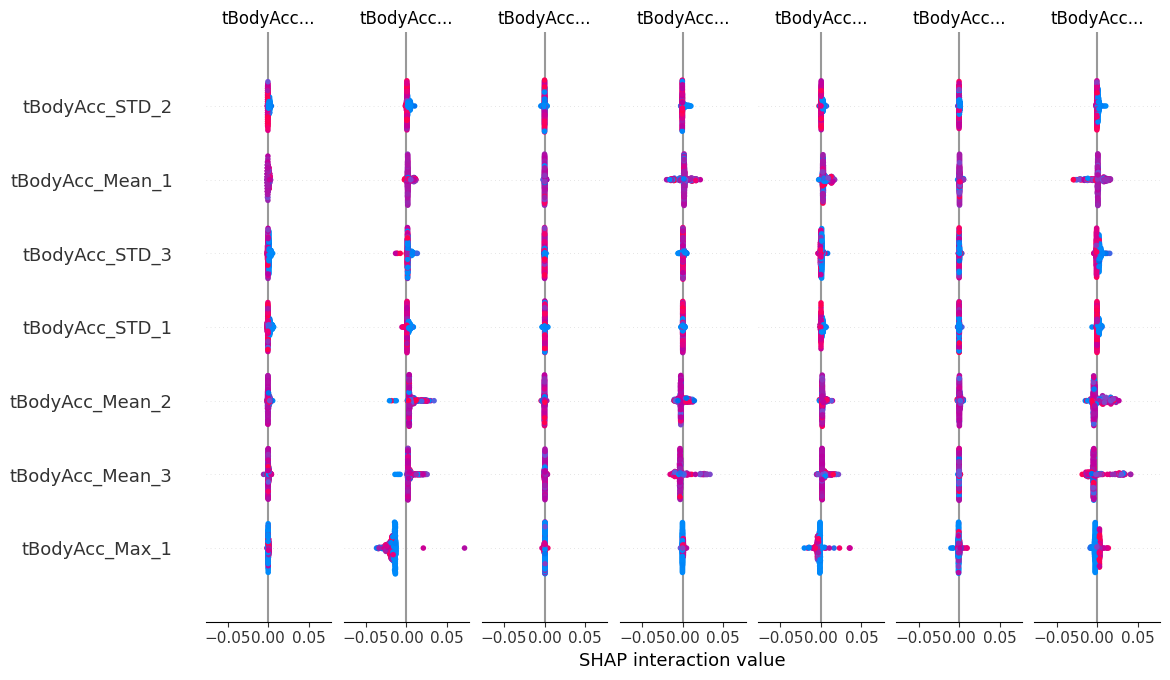

In [23]:
try:
    import shap
except Exception:
    shap = None

# Quick feature importance
fi = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
display(fi.head(30))
plt.figure(figsize=(10,6)); fi.head(30).plot(kind='bar'); plt.title('RF feature importances (top30)'); plt.show()

if shap is not None:
    explainer = shap.TreeExplainer(rf)
    Xs = X_test.sample(min(300, X_test.shape[0]), random_state=RANDOM_STATE)
    sv = explainer.shap_values(Xs)
    shap.summary_plot(sv, Xs)
else:
    print('shap not installed — install shap for deeper explanations')

## Notes
- Do not use test set for tuning. Use internal CV on training data for hyperparameter selection.
- For experiments that use feature subsets (e.g., time vs freq), select columns from X_train before fitting and apply the same subset to X_test using the saved column list.
- Saved artifacts: models/rf_quick.joblib, models/feature_columns_order.joblib, models/const_cols.joblib
